Example of how to use codebase to analyse importance of weights in CNN model zoo

In [1]:
# imports
import torch as th
import numpy as np
import matplotlib.pyplot as plt

# Load Data
We load data from Unterthiner's small CNN model zoo. The metrics are enriched with per class accuracy for every model.

In [2]:
from utils.load_dataset import load_dataset
dataset = 'fashion_mnist'
weights_train, weights_test, outputs_train, outputs_test, configs_train, configs_tes = load_dataset(dataset, metrics_file='metrics_merged.csv', load_class_acc=True)
train_class_accuracies = outputs_train[:, -10:]
test_class_accuracies = outputs_test[:, -10:]

# Get probe/lens model
We train an MLP regressor model to predict per class accuracy. If the regressor is of sufficiently good quality, i.e. it predicts class accuracy with a small enough MSE, we might learn what weights are important for predicitng per class accuracy from studying this probe/lens.

In [3]:
from lenses.regressor_lens import get_regressor_lens
regressor_lens = get_regressor_lens(weights_train, train_class_accuracies, weights_test, test_class_accuracies)

Epoch   1 ─ val MSE 0.033777 | val MAE 0.119523
Epoch   2 ─ val MSE 0.021162 | val MAE 0.085819
Epoch   3 ─ val MSE 0.020462 | val MAE 0.083857
Epoch   4 ─ val MSE 0.020220 | val MAE 0.078781
Epoch   5 ─ val MSE 0.018480 | val MAE 0.072888
Epoch   6 ─ val MSE 0.018711 | val MAE 0.074877
Epoch   7 ─ val MSE 0.020153 | val MAE 0.075046
Epoch   8 ─ val MSE 0.017825 | val MAE 0.072453
Epoch   9 ─ val MSE 0.017684 | val MAE 0.069066
Epoch  10 ─ val MSE 0.018526 | val MAE 0.071141
Epoch  11 ─ val MSE 0.017948 | val MAE 0.070912
Epoch  12 ─ val MSE 0.017603 | val MAE 0.069603
Epoch  13 ─ val MSE 0.017851 | val MAE 0.070383
Epoch  14 ─ val MSE 0.017656 | val MAE 0.070592
Epoch  15 ─ val MSE 0.019552 | val MAE 0.073399
Epoch  16 ─ val MSE 0.017407 | val MAE 0.068203
Epoch  17 ─ val MSE 0.018520 | val MAE 0.069839
Epoch  18 ─ val MSE 0.017269 | val MAE 0.067789
Epoch  19 ─ val MSE 0.018450 | val MAE 0.073586
Epoch  20 ─ val MSE 0.017355 | val MAE 0.068728
Epoch  21 ─ val MSE 0.017345 | val MAE 0

Our regressor lens can make predictions on class accuracy

CNN model index: 16
Label class accuracy for CNN model 16: [0.882 0.98  0.859 0.86  0.853 0.976 0.514 0.948 0.968 0.942]
Predicted class accuracy: [0.8616727  0.98749965 0.8693022  0.9172909  0.83749646 0.9798043
 0.6035811  0.9689062  0.9873673  0.9849953 ]


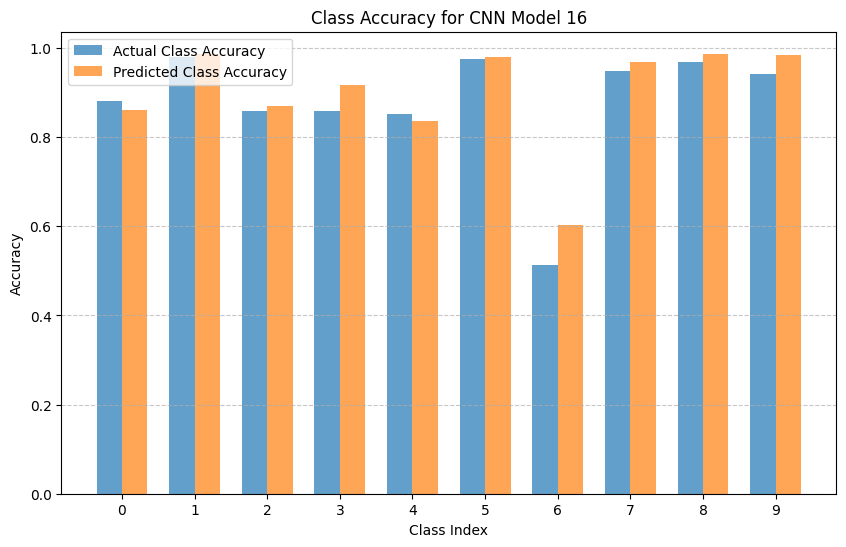

In [4]:
# Define the CNN model index and retrieve its weights and class accuracy
CNN_index = 16  # Example index of a CNN model in the dataset
CNN_weights = weights_train[CNN_index]
CNN_class_accuracy = train_class_accuracies[CNN_index]

# Print model details
print(f"CNN model index: {CNN_index}")
print(f"Label class accuracy for CNN model {CNN_index}: {CNN_class_accuracy}")

# Predict class accuracy using the regressor lens
predicted_class_accuracy = regressor_lens.forward(
    th.tensor(CNN_weights, dtype=th.float32).unsqueeze(0)
).detach().numpy().flatten()
print(f"Predicted class accuracy: {predicted_class_accuracy}")

# Plot the predicted and actual class accuracies as a bar plot
plt.figure(figsize=(10, 6))
width = 0.35  # Width of the bars
x = np.arange(len(CNN_class_accuracy))  # Class indices

# Plot actual class accuracy
plt.bar(x - width / 2, CNN_class_accuracy, width, label="Actual Class Accuracy", alpha=0.7)

# Plot predicted class accuracy
plt.bar(x + width / 2, predicted_class_accuracy, width, label="Predicted Class Accuracy", alpha=0.7)

# Add plot details
plt.title(f"Class Accuracy for CNN Model {CNN_index}")
plt.xlabel("Class Index")
plt.ylabel("Accuracy")
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Attribution analysis
By studying the regressor lens, we might learn which CNN weights are important for the regressor to make it's predicition. Let's try an attribution method; Integrated Gradients

In [5]:
from captum.attr import IntegratedGradients

ig = IntegratedGradients(regressor_lens)

attributions = {}  # attributions for each class

for class_idx in range(10):
    attributions[class_idx] = ig.attribute(
        th.tensor(CNN_weights, dtype=th.float32).unsqueeze(0),
        target=class_idx,
).flatten().detach().numpy()

/Users/ilic/Documents/CWI/Explainability and Interpretability/WeightSpaceClassifier/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's plot the results (zoom in and scroll around)

In [6]:
import plotly.graph_objects as go

# Create a grouped bar chart
fig = go.Figure()

for class_idx, class_attributions in attributions.items():
    mean_attributions = class_attributions
    fig.add_trace(go.Bar(
        x=list(range(len(mean_attributions))),
        y=mean_attributions,
        name=f'Class {class_idx}',
        width=0.9,
        opacity=0.7,
    ))

# Add layout details
fig.update_layout(
    title=f'Attributions Across input CNN weights for predicting accuracy for Each Class for {dataset} CNN Model {CNN_index}',
    xaxis_title='Feature Index (Weight Index)',
    yaxis_title='Attribution Value',
    barmode='overlay',  # Align bars for each dataset
    legend_title='Classes'
)

fig.show()